## 1. Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")

✓ Libraries imported successfully
PyTorch version: 2.9.0+cu128


## 2. Data Simulator

Same simulator as before, but we'll demonstrate DINGO's ability to handle more complex scenarios.

In [3]:
def simulate_sine_wave(amplitude, num_points=100, noise_std=0.1):
    """
    Generate a sine wave with given amplitude and add noise
    
    Args:
        amplitude: amplitude of sine wave (parameter we want to infer)
        num_points: number of time points
        noise_std: standard deviation of Gaussian noise
    
    Returns:
        observed_data: noisy sine wave observations
    """
    t = np.linspace(0, 2*np.pi, num_points)
    signal = amplitude * np.sin(t)
    noise = np.random.normal(0, noise_std, num_points)
    observed_data = signal + noise
    return observed_data

print("✓ Simulator ready")

✓ Simulator ready


## 3. Normalizing Flow Components

DINGO uses **normalizing flows** to transform a simple base distribution (e.g., Gaussian) into a complex posterior distribution.

We'll implement:
1. **Coupling layers** - Core flow transformation
2. **Base distribution** - Standard Gaussian
3. **Flow composition** - Stack multiple transformations

In [4]:
class AffineCouplingLayer(nn.Module):
    """
    Affine coupling layer for normalizing flows
    
    Splits input, transforms one half conditioned on the other:
    x2_new = x2 * exp(s(x1, context)) + t(x1, context)
    """
    def __init__(self, dim, context_dim, hidden_dim=128, mask_type='half'):
        super().__init__()
        self.dim = dim
        
        # Create mask (which dimensions to transform)
        self.register_buffer('mask', torch.zeros(dim))
        if mask_type == 'half':
            self.mask[:dim // 2] = 1
        
        # Networks for scale (s) and translation (t)
        self.scale_net = nn.Sequential(
            nn.Linear(dim + context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()  # Stabilize training
        )
        
        self.translation_net = nn.Sequential(
            nn.Linear(dim + context_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
    
    def forward(self, x, context, reverse=False):
        """
        Forward (data -> latent) or reverse (latent -> data) transformation
        
        Args:
            x: input tensor [batch_size, dim]
            context: conditioning context (embedded data) [batch_size, context_dim]
            reverse: if True, compute inverse transformation
        
        Returns:
            output: transformed tensor
            log_det: log determinant of Jacobian
        """
        masked_x = x * self.mask # Split data into a masked and unmasked part. 
                                 # The unmasked part is kept the same and is used for conditioning. The masked part is set to 0, to be transformed (but how does this work?)
        
        # Concatenate masked input with context
        scale_input = torch.cat([masked_x, context], dim=1) 
        translation_input = torch.cat([masked_x, context], dim=1) # These two literally concatenate masked_x and context along. 
                                                                  # So if masked_x is [2.5] and context is [0.3, -0.1, ...], then scale_input is [2.5, 0.3, -0.1, ...]
                                                                  # In this case, context is a compressed sine wave, and masked_x is the amplitude. So the first number in this concatenation is the amplitude, and the rest are the sine wave values.
                                                                  # So of course, during training, the network is passed thousands of these examples, so it learns that the first number is the amplitude, and the rest are the sine wave values.
                                                                  # So when 
        # Compute scale and translation
        s = self.scale_net(scale_input)
        t = self.translation_net(translation_input)
        
        # Only apply to unmasked dimensions
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)
        
        if not reverse:
            # Forward: x -> z
            y = x * torch.exp(s) + t
            log_det = s.sum(dim=1)
        else:
            # Reverse: z -> x
            y = (x - t) * torch.exp(-s)
            log_det = -s.sum(dim=1)
        
        return y, log_det

print("✓ Coupling layer defined")

✓ Coupling layer defined


In [5]:
class NormalizingFlow(nn.Module):
    """
    Normalizing flow: stack of coupling layers
    Transforms base distribution into complex posterior
    """
    def __init__(self, param_dim=1, context_dim=64, num_layers=6, hidden_dim=128):
        super().__init__()
        self.param_dim = param_dim
        self.context_dim = context_dim
        
        # Stack of coupling layers with alternating masks
        self.layers = nn.ModuleList([
            AffineCouplingLayer(
                dim=param_dim,
                context_dim=context_dim,
                hidden_dim=hidden_dim,
                mask_type='half' if i % 2 == 0 else 'half'
            )
            for i in range(num_layers)
        ])
        
        # Base distribution: standard Gaussian
        self.register_buffer('base_mean', torch.zeros(param_dim))
        self.register_buffer('base_std', torch.ones(param_dim))
    
    def forward(self, params, context):
        """
        Forward pass: compute log probability of parameters given context
        
        Args:
            params: parameter values [batch_size, param_dim]
            context: embedded observed data [batch_size, context_dim]
        
        Returns:
            log_prob: log p(params | context)
        """
        z = params
        log_det_sum = 0
        
        # Apply flow transformations
        for layer in self.layers:
            z, log_det = layer(z, context, reverse=False)
            log_det_sum += log_det
        
        # Compute log probability under base distribution
        log_prob_base = -0.5 * (torch.log(2 * np.pi * self.base_std**2) + 
                                 ((z - self.base_mean) / self.base_std)**2)
        log_prob_base = log_prob_base.sum(dim=1)
        
        # Apply change of variables
        log_prob = log_prob_base + log_det_sum
        
        return log_prob
    
    def sample(self, context, num_samples=1):
        """
        Sample from posterior p(params | context)
        
        Args:
            context: embedded observed data [batch_size, context_dim]
            num_samples: number of samples per context
        
        Returns:
            samples: parameter samples [batch_size * num_samples, param_dim]
        """
        batch_size = context.shape[0]
        
        # Repeat context for multiple samples
        context_repeated = context.repeat_interleave(num_samples, dim=0)
        
        # Sample from base distribution
        z = torch.randn(batch_size * num_samples, self.param_dim, device=context.device)
        
        # Apply inverse flow transformations
        for layer in reversed(self.layers):
            z, _ = layer(z, context_repeated, reverse=True)
        
        return z

print("✓ Normalizing flow defined")

✓ Normalizing flow defined


## 4. Embedding Network

DINGO uses an embedding network to compress raw data into a lower-dimensional representation ("context") that conditions the flow.

In [6]:
class EmbeddingNetwork(nn.Module):
    """
    Neural network to embed observed data into context vector
    Similar to DINGO's data compression network
    """
    def __init__(self, data_dim=100, context_dim=64, hidden_dim=128):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, context_dim)
        )
    
    def forward(self, data):
        """
        Args:
            data: observed data [batch_size, data_dim]
        
        Returns:
            context: embedded representation [batch_size, context_dim]
        """
        return self.network(data)

print("✓ Embedding network defined")

✓ Embedding network defined


## 5. Complete DINGO-style Model

Combines embedding network + normalizing flow

In [7]:
class DINGOModel(nn.Module):
    """
    Complete DINGO-style neural posterior estimation model
    
    Architecture:
    observed_data -> EmbeddingNet -> context -> NormalizingFlow -> log p(params | data)
    """
    def __init__(self, data_dim=100, param_dim=1, context_dim=64, 
                 num_flow_layers=6, hidden_dim=128):
        super().__init__()
        
        self.embedding_net = EmbeddingNetwork(
            data_dim=data_dim,
            context_dim=context_dim,
            hidden_dim=hidden_dim
        )
        
        self.flow = NormalizingFlow(
            param_dim=param_dim,
            context_dim=context_dim,
            num_layers=num_flow_layers,
            hidden_dim=hidden_dim
        )
    
    def forward(self, params, data):
        """
        Compute log probability of parameters given data
        
        Args:
            params: parameter values [batch_size, param_dim]
            data: observed data [batch_size, data_dim]
        
        Returns:
            log_prob: log p(params | data)
        """
        context = self.embedding_net(data)
        log_prob = self.flow(params, context)
        return log_prob
    
    def sample_posterior(self, data, num_samples=1000):
        """
        Sample from posterior p(params | data)
        
        Args:
            data: observed data [batch_size, data_dim]
            num_samples: number of samples to draw
        
        Returns:
            samples: posterior samples [batch_size * num_samples, param_dim]
        """
        self.eval()
        with torch.no_grad():
            context = self.embedding_net(data)
            samples = self.flow.sample(context, num_samples=num_samples)
        return samples

# Create model
model = DINGOModel(
    data_dim=100,
    param_dim=1,
    context_dim=64,
    num_flow_layers=8,
    hidden_dim=128
)

print("✓ DINGO-style model created")
print(f"\nModel components:")
print(f"  - Embedding network: {sum(p.numel() for p in model.embedding_net.parameters()):,} parameters")
print(f"  - Normalizing flow: {sum(p.numel() for p in model.flow.parameters()):,} parameters")
print(f"  - Total: {sum(p.numel() for p in model.parameters()):,} parameters")

✓ DINGO-style model created

Model components:
  - Embedding network: 54,208 parameters
  - Normalizing flow: 401,424 parameters
  - Total: 455,632 parameters


## 6. Generate Training Data

In [8]:
def generate_training_data(num_simulations=10000, prior_low=0.5, prior_high=5.0):
    """
    Generate training dataset for DINGO-style NPE
    """
    print(f"Generating {num_simulations} training simulations...")
    
    train_amplitudes = []
    train_data = []
    
    for i in range(num_simulations):
        # Sample amplitude from prior
        amplitude = np.random.uniform(prior_low, prior_high)
        # Simulate observed data
        observed = simulate_sine_wave(amplitude)
        
        train_amplitudes.append(amplitude)
        train_data.append(observed)
        
        if (i + 1) % 2000 == 0:
            print(f"  Generated {i+1}/{num_simulations} simulations")
    
    train_amplitudes = torch.FloatTensor(train_amplitudes).unsqueeze(1)  # [N, 1]
    train_data = torch.FloatTensor(np.array(train_data))  # [N, 100]
    
    print(f"✓ Training data generated")
    print(f"  Amplitudes shape: {train_amplitudes.shape}")
    print(f"  Data shape: {train_data.shape}")
    
    return train_amplitudes, train_data

# Generate training data
train_amplitudes, train_data = generate_training_data(num_simulations=10000)

Generating 10000 training simulations...
  Generated 2000/10000 simulations
  Generated 4000/10000 simulations
  Generated 6000/10000 simulations
  Generated 8000/10000 simulations
  Generated 10000/10000 simulations
✓ Training data generated
  Amplitudes shape: torch.Size([10000, 1])
  Data shape: torch.Size([10000, 100])


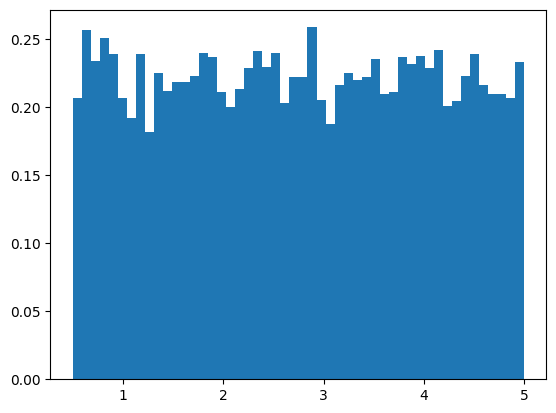

In [22]:
plt.hist(train_amplitudes.numpy(), bins=50, density=True)
plt.show()

## 7. Training Loop

Train using maximum likelihood: maximize $\log p(\theta | x)$ for each training pair $(\theta, x)$

In [14]:
def train_dingo_model(model, train_amplitudes, train_data, 
                      num_epochs=100, batch_size=256, lr=5e-4):
    """
    Train the DINGO-style model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10
    )
    
    num_simulations = len(train_amplitudes)
    
    print(f"Training DINGO-style model for {num_epochs} epochs...\n")
    
    losses = []
    best_loss = -float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        num_batches = 0
        
        # Shuffle and create batches
        indices = torch.randperm(num_simulations)
        
        for i in range(0, num_simulations, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_data = train_data[batch_indices]
            batch_amplitudes = train_amplitudes[batch_indices]
            
            # Forward pass: compute log probability
            log_prob = model(batch_amplitudes, batch_data)
            
            # Loss: negative log likelihood
            loss = -log_prob.mean()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            
            optimizer.step()
            
            epoch_loss += -loss.item()  # Convert back to log prob
            num_batches += 1
        
        avg_log_prob = epoch_loss / num_batches
        losses.append(avg_log_prob)
        
        # Learning rate scheduling
        scheduler.step(avg_log_prob)
        
        if avg_log_prob > best_loss:
            best_loss = avg_log_prob
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Avg Log Prob: {avg_log_prob:.4f}, Best: {best_loss:.4f}")
    
    print("\n✓ Training complete!")
    return losses

# Train the model
losses = train_dingo_model(
    model, 
    train_amplitudes, 
    train_data, 
    num_epochs=100, 
    batch_size=256,
    lr=5e-4
)

Training DINGO-style model for 100 epochs...

Epoch 10/100, Avg Log Prob: 1.5192, Best: 1.5451
Epoch 20/100, Avg Log Prob: 1.5320, Best: 1.6084
Epoch 30/100, Avg Log Prob: 2.1303, Best: 2.1743
Epoch 40/100, Avg Log Prob: 2.5441, Best: 2.5441
Epoch 50/100, Avg Log Prob: 2.5366, Best: 2.5468
Epoch 60/100, Avg Log Prob: 2.5277, Best: 2.5490
Epoch 70/100, Avg Log Prob: 2.7365, Best: 2.7365
Epoch 80/100, Avg Log Prob: 2.6210, Best: 2.8008
Epoch 90/100, Avg Log Prob: 2.7862, Best: 2.8028
Epoch 100/100, Avg Log Prob: 2.7777, Best: 2.8106

✓ Training complete!


### Plot Training Progress

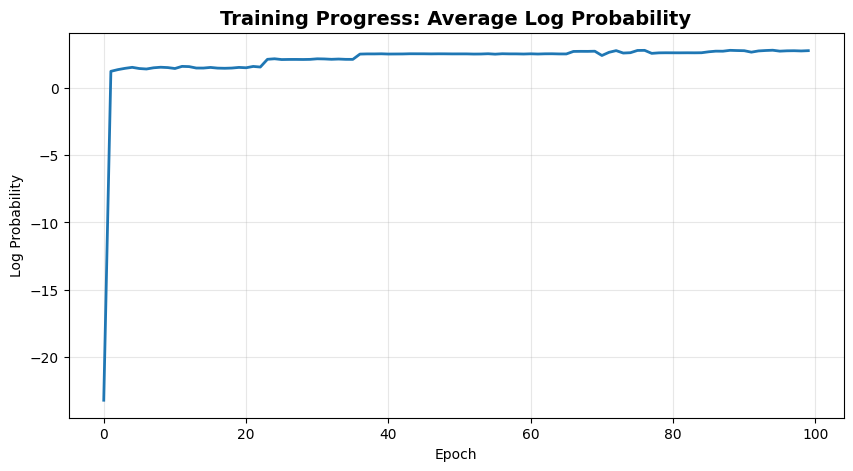

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2)
plt.title('Training Progress: Average Log Probability', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Log Probability')
plt.grid(True, alpha=0.3)
plt.show()

## 8. Inference with DINGO Model

Now we can sample from the learned posterior distribution for any new observation.

In [16]:
def infer_with_dingo(model, observed_data, num_samples=5000):
    """
    Perform inference using the DINGO-style model
    
    Args:
        model: trained DINGO model
        observed_data: observed sine wave [data_dim]
        num_samples: number of posterior samples
    
    Returns:
        samples: posterior samples
        statistics: dict with mean, median, std, quantiles
    """
    model.eval()
    
    # Prepare data
    data_tensor = torch.FloatTensor(observed_data).unsqueeze(0)  # [1, data_dim]
    
    # Sample from posterior
    with torch.no_grad():
        samples = model.sample_posterior(data_tensor, num_samples=num_samples)
        samples = samples.numpy().flatten()
    
    # Compute statistics
    statistics = {
        'mean': np.mean(samples),
        'median': np.median(samples),
        'std': np.std(samples),
        'q05': np.percentile(samples, 5),
        'q95': np.percentile(samples, 95),
    }
    
    return samples, statistics

print("✓ Inference function ready")

✓ Inference function ready


## 9. Test DINGO Model

Let's test on multiple amplitudes and visualize the posteriors.

Testing DINGO model on new observations:


Test 1: True Amplitude = 1.0
  Posterior mean: 0.998 ± 0.014
  Posterior median: 0.998
  90% CI: [0.975, 1.021]
  Error: 0.002

Test 2: True Amplitude = 2.5
  Posterior mean: 2.497 ± 0.014
  Posterior median: 2.497
  90% CI: [2.474, 2.521]
  Error: 0.003

Test 3: True Amplitude = 4.0
  Posterior mean: 4.019 ± 0.015
  Posterior median: 4.019
  90% CI: [3.995, 4.042]
  Error: 0.019


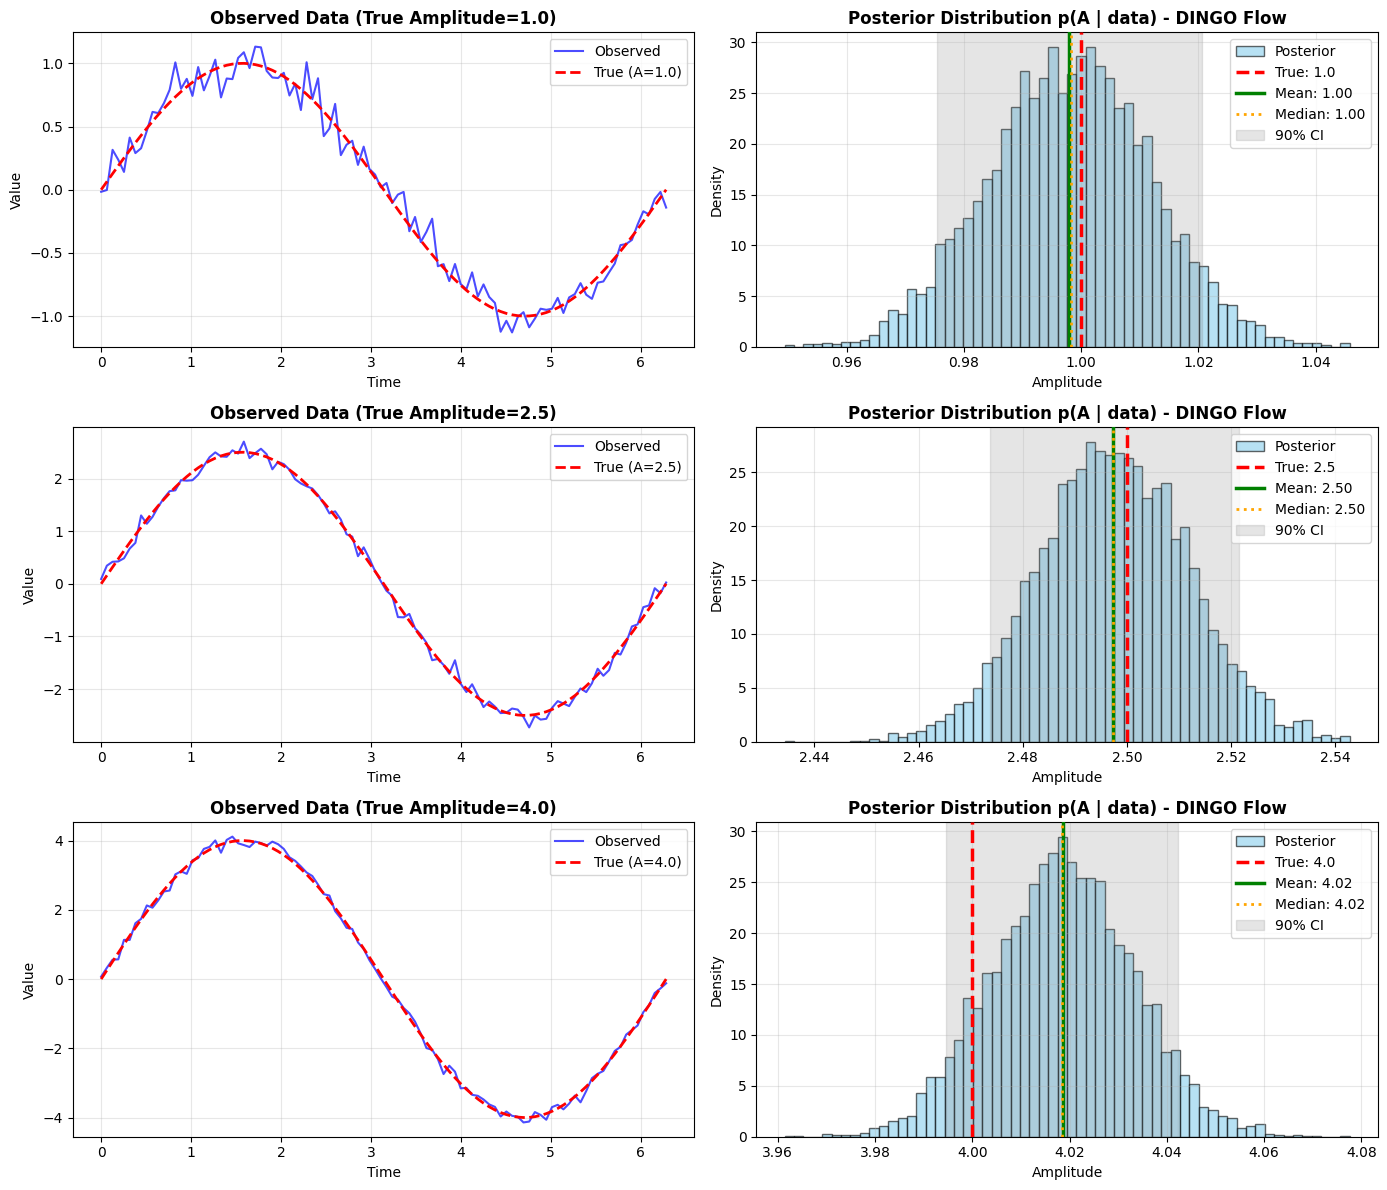


✓ DINGO-style model successfully learned amplitude posteriors!
  The normalizing flow provides flexible, non-Gaussian posteriors.


In [17]:
# Test on several different true amplitudes
test_amplitudes = [1.0, 2.5, 4.0]

fig, axes = plt.subplots(len(test_amplitudes), 2, figsize=(14, 4*len(test_amplitudes)))

print("Testing DINGO model on new observations:\n")
print("="*70)

for idx, true_amplitude in enumerate(test_amplitudes):
    print(f"\nTest {idx+1}: True Amplitude = {true_amplitude}")
    
    # Generate new observation
    observed_data = simulate_sine_wave(true_amplitude)
    
    # Infer posterior
    posterior_samples, stats = infer_with_dingo(model, observed_data, num_samples=5000)
    
    error = abs(true_amplitude - stats['mean'])
    print(f"  Posterior mean: {stats['mean']:.3f} ± {stats['std']:.3f}")
    print(f"  Posterior median: {stats['median']:.3f}")
    print(f"  90% CI: [{stats['q05']:.3f}, {stats['q95']:.3f}]")
    print(f"  Error: {error:.3f}")
    
    # Plot observed data
    t = np.linspace(0, 2*np.pi, 100)
    axes[idx, 0].plot(t, observed_data, 'b-', alpha=0.7, linewidth=1.5, label='Observed')
    axes[idx, 0].plot(t, true_amplitude * np.sin(t), 'r--', 
                      label=f'True (A={true_amplitude})', linewidth=2)
    axes[idx, 0].set_title(f'Observed Data (True Amplitude={true_amplitude})', 
                           fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel('Time')
    axes[idx, 0].set_ylabel('Value')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Plot posterior distribution
    axes[idx, 1].hist(posterior_samples, bins=60, density=True, 
                      alpha=0.6, color='skyblue', edgecolor='black', label='Posterior')
    
    # Add vertical lines for statistics
    axes[idx, 1].axvline(true_amplitude, color='red', linestyle='--', 
                         linewidth=2.5, label=f'True: {true_amplitude}', zorder=10)
    axes[idx, 1].axvline(stats['mean'], color='green', linestyle='-', 
                         linewidth=2.5, label=f"Mean: {stats['mean']:.2f}", zorder=10)
    axes[idx, 1].axvline(stats['median'], color='orange', linestyle=':', 
                         linewidth=2, label=f"Median: {stats['median']:.2f}", zorder=10)
    
    # Shade 90% credible interval
    axes[idx, 1].axvspan(stats['q05'], stats['q95'], alpha=0.2, color='gray', 
                         label='90% CI')
    
    axes[idx, 1].set_title(f'Posterior Distribution p(A | data) - DINGO Flow', 
                           fontsize=12, fontweight='bold')
    axes[idx, 1].set_xlabel('Amplitude')
    axes[idx, 1].set_ylabel('Density')
    axes[idx, 1].legend(loc='upper right')
    axes[idx, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✓ DINGO-style model successfully learned amplitude posteriors!")
print("  The normalizing flow provides flexible, non-Gaussian posteriors.")
print("="*70)

## 10. Compare DINGO vs Simple NPE

Let's demonstrate DINGO's advantage on a more complex scenario.

Testing with custom amplitude: 3.2

True amplitude: 3.2
Inferred mean: 3.211 ± 0.015
Inferred median: 3.211
90% Credible Interval: [3.187, 3.235]
Error: 0.011


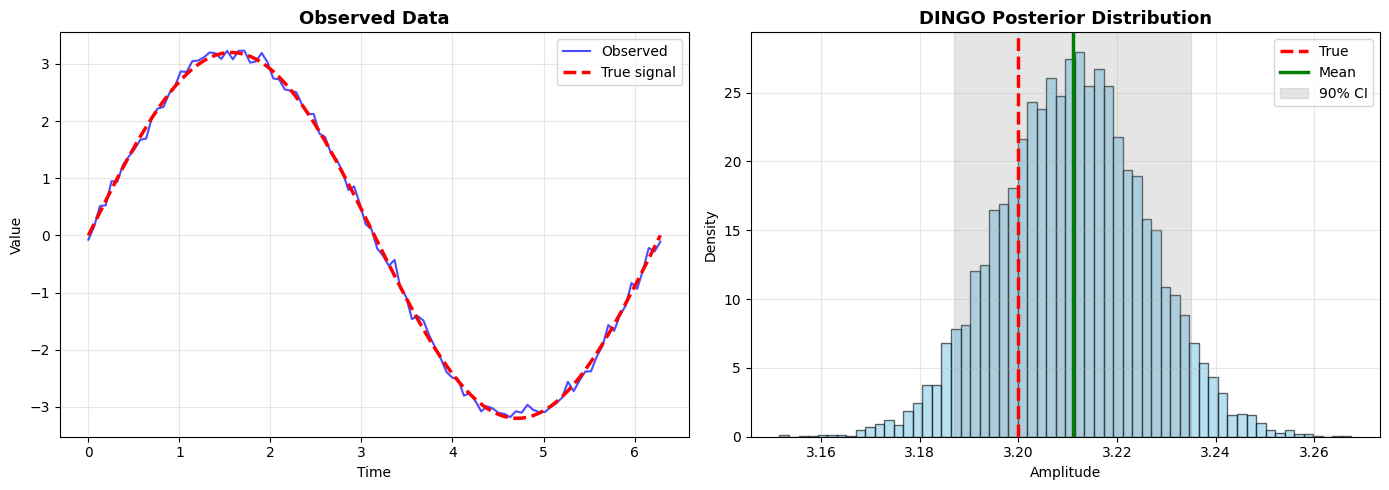

In [18]:
# Test with a custom amplitude
custom_amplitude = 3.2

print(f"Testing with custom amplitude: {custom_amplitude}\n")

# Generate observation and infer
observed = simulate_sine_wave(custom_amplitude)
samples, stats = infer_with_dingo(model, observed, num_samples=10000)

print(f"True amplitude: {custom_amplitude}")
print(f"Inferred mean: {stats['mean']:.3f} ± {stats['std']:.3f}")
print(f"Inferred median: {stats['median']:.3f}")
print(f"90% Credible Interval: [{stats['q05']:.3f}, {stats['q95']:.3f}]")
print(f"Error: {abs(custom_amplitude - stats['mean']):.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

t = np.linspace(0, 2*np.pi, 100)
axes[0].plot(t, observed, 'b-', alpha=0.7, linewidth=1.5, label='Observed')
axes[0].plot(t, custom_amplitude * np.sin(t), 'r--', linewidth=2.5, label='True signal')
axes[0].set_title('Observed Data', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(samples, bins=60, density=True, alpha=0.6, color='skyblue', edgecolor='black')
axes[1].axvline(custom_amplitude, color='red', linestyle='--', linewidth=2.5, label='True')
axes[1].axvline(stats['mean'], color='green', linestyle='-', linewidth=2.5, label='Mean')
axes[1].axvspan(stats['q05'], stats['q95'], alpha=0.2, color='gray', label='90% CI')
axes[1].set_title('DINGO Posterior Distribution', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Amplitude')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Visualize Flow Transformations

Let's see how the normalizing flow transforms the base Gaussian distribution.

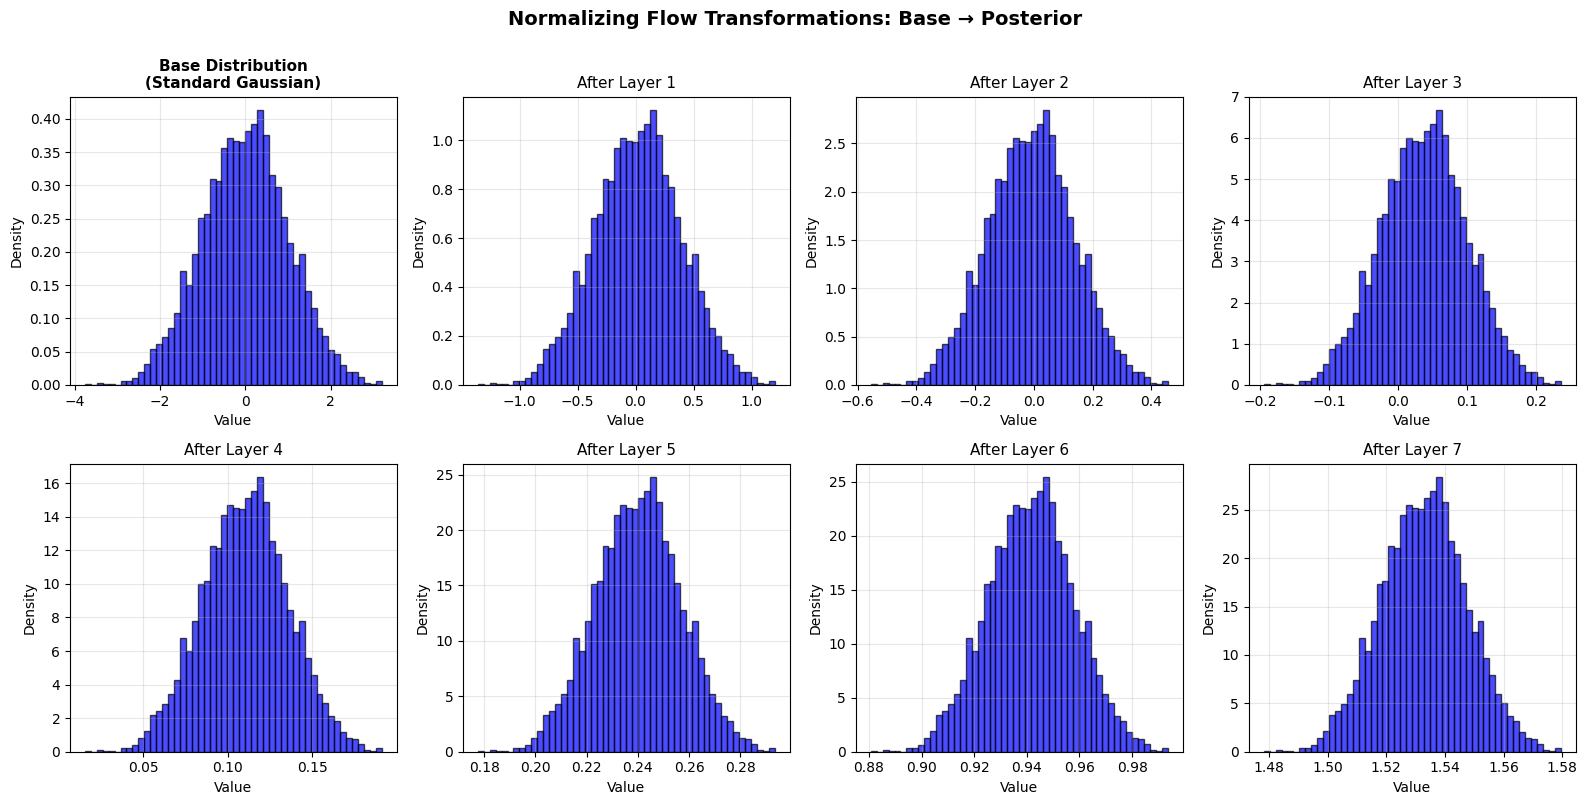

In [19]:
# Pick an observation
test_amplitude = 2.5
test_observation = simulate_sine_wave(test_amplitude)
data_tensor = torch.FloatTensor(test_observation).unsqueeze(0)

# Get context embedding
model.eval()
with torch.no_grad():
    context = model.embedding_net(data_tensor)

# Sample from base distribution
num_viz_samples = 5000
z_base = torch.randn(num_viz_samples, 1)

# Transform through each layer
transformations = [z_base.numpy().flatten()]
z = z_base
context_repeated = context.repeat(num_viz_samples, 1)

with torch.no_grad():
    for layer in reversed(model.flow.layers):
        z, _ = layer(z, context_repeated, reverse=True)
        transformations.append(z.numpy().flatten())

# Plot transformations
num_layers = len(transformations)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, (ax, samples) in enumerate(zip(axes[:num_layers], transformations)):
    ax.hist(samples, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
    if i == 0:
        ax.set_title('Base Distribution\n(Standard Gaussian)', fontsize=11, fontweight='bold')
    elif i == num_layers - 1:
        ax.axvline(test_amplitude, color='red', linestyle='--', linewidth=2, label='True')
        ax.set_title('Final Posterior', fontsize=11, fontweight='bold')
        ax.legend()
    else:
        ax.set_title(f'After Layer {i}', fontsize=11)
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for i in range(num_layers, len(axes)):
    axes[i].axis('off')

plt.suptitle('Normalizing Flow Transformations: Base → Posterior', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## Summary: DINGO-style NPE

### What We Implemented:

1. **Normalizing Flows**: Flexible transformations that can learn complex, non-Gaussian posteriors
2. **Embedding Network**: Compresses high-dimensional data into context representation
3. **Conditional Flow**: Posterior depends on observed data through context conditioning
4. **Invertible Transformations**: Can both evaluate probability and sample efficiently

### Key Advantages over Simple NPE:

✓ **More Flexible**: Can capture multimodal, skewed, or otherwise non-Gaussian posteriors  
✓ **Scalable**: Architecture used in production (DINGO for gravitational waves)  
✓ **Exact Likelihood**: Provides exact probability evaluation via change of variables  
✓ **Fast Sampling**: Efficient posterior sampling through inverse flow  

### Architecture Summary:

```
Raw Data (100D) 
    ↓
Embedding Network
    ↓
Context Vector (64D)
    ↓
Normalizing Flow (8 layers)
    ↓
Posterior p(amplitude | data)
```

This architecture is similar to what's used in real gravitational-wave inference with DINGO!